'NASA Turbofan Dataset' is used. There are different subsets based on the fault modes. This notebook uses FD001.

# Import of libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

# Data Analysis

The dataset is available in text format. Therefore, they are converted to dataframes with addition of headings. 

In [7]:
# headings
index_names = ['engine_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s{}'.format(i) for i in range(1,22)]

column_names = index_names + setting_names + sensor_names 

In [8]:
# data loading
train_data = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt', sep = '\s+', header = None, names = column_names)
test_data = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt', sep = '\s+', header = None, names = column_names)

In [9]:
# inspect
train_data.head()

,engine_number,time_cycles,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [10]:
test_data.head()

,engine_number,time_cycles,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [11]:
train_data[index_names].describe()

,engine_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [12]:
# understanding time cycles
train_data[index_names].groupby('engine_number').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


First engine failure occurs after 128 time_cycles and last engine failure occurs after 362 time_cycles.

In [13]:
# understanding sensor data
train_data[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


s1, s5, s6, s10, s16, s18 and s19 are not useful because of their constant nature. Remaining Useful Life ('RUL') is calculated for training set. Note that RUL is clipped to an upper limit of 125. This is a better assumption as compared to earlier linear decrease over time. Check the sensor data to understand this visually.  

In [14]:
train_data['rul'] = train_data.groupby('engine_number')['time_cycles'].apply(lambda x: x.max() - x).apply(lambda x: min(x,125))
train_data.head()

,engine_number,time_cycles,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,125
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,125
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,125
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,125


# Signal Plotting

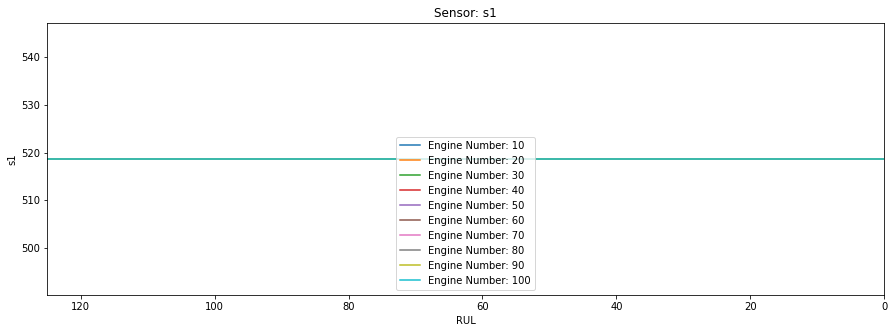

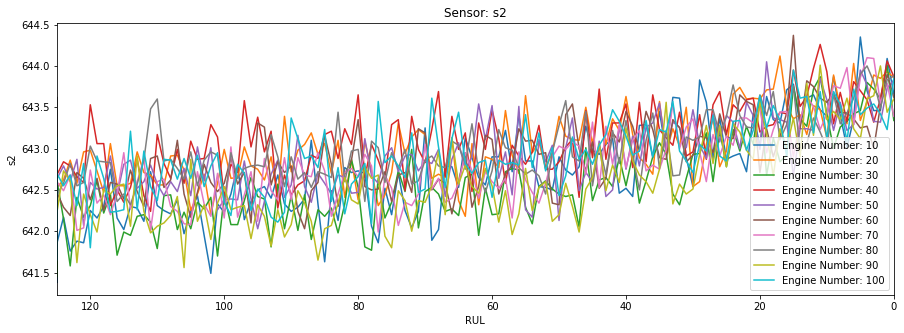

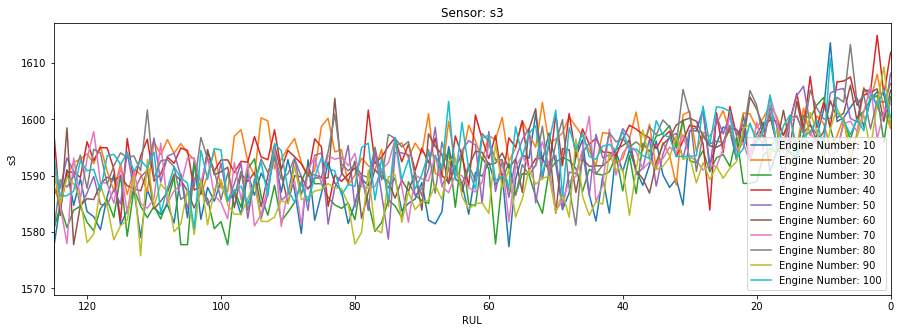

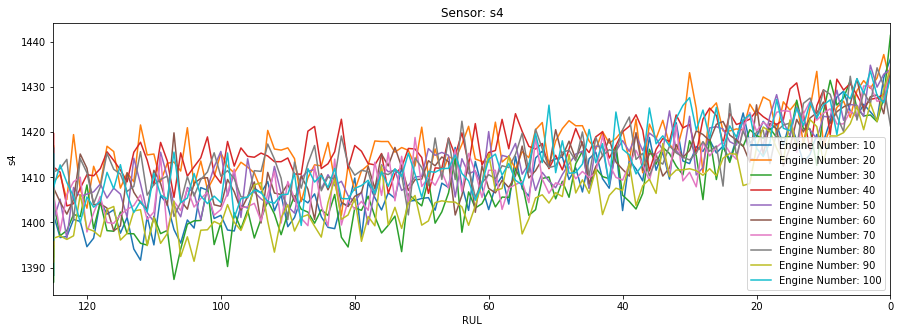

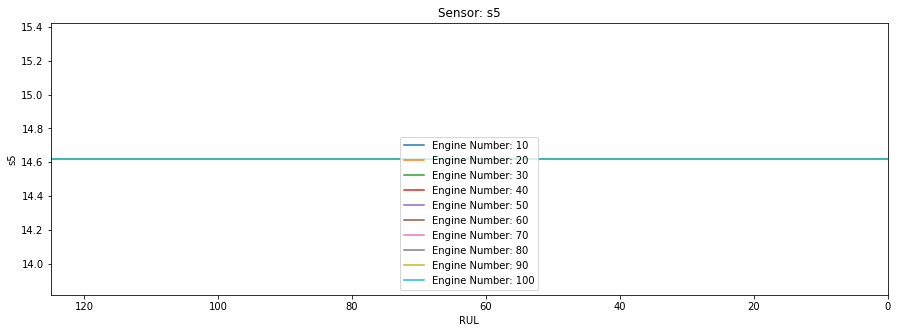

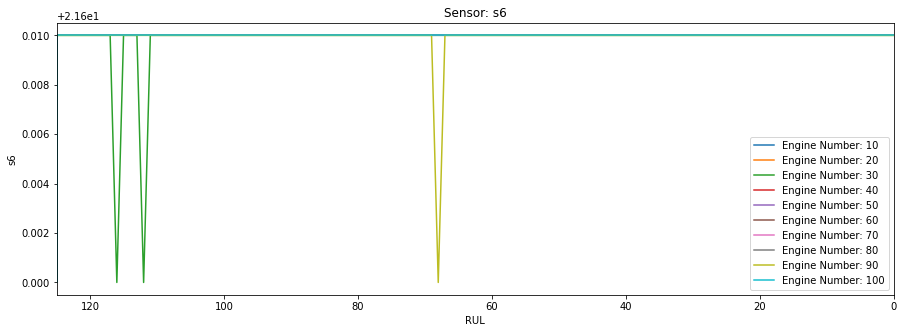

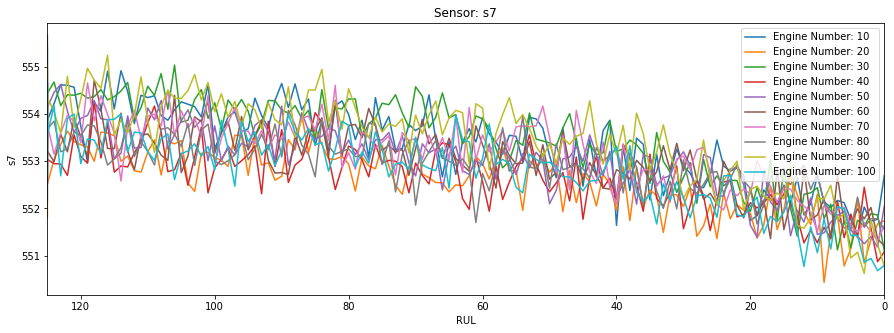

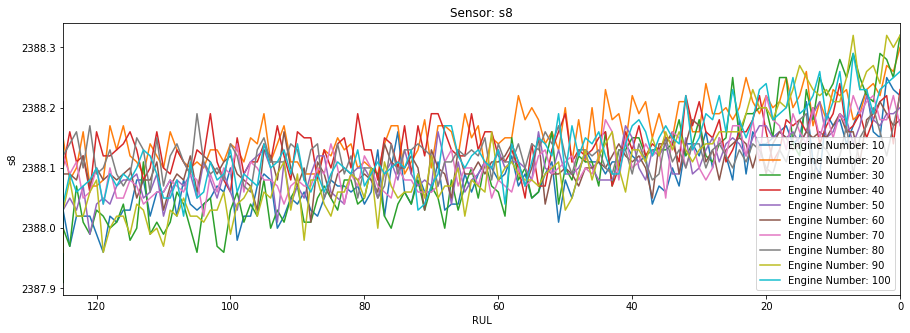

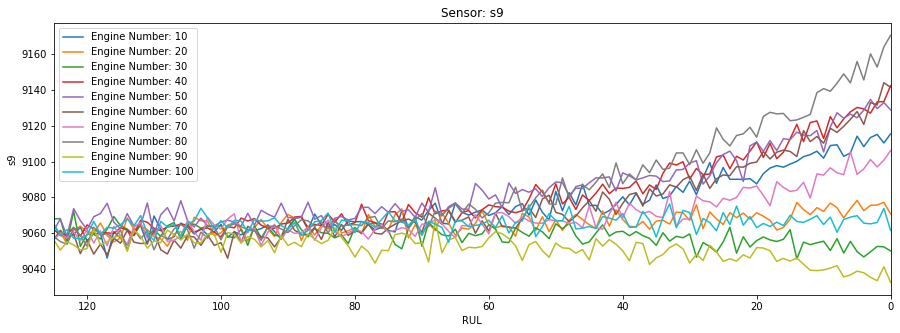

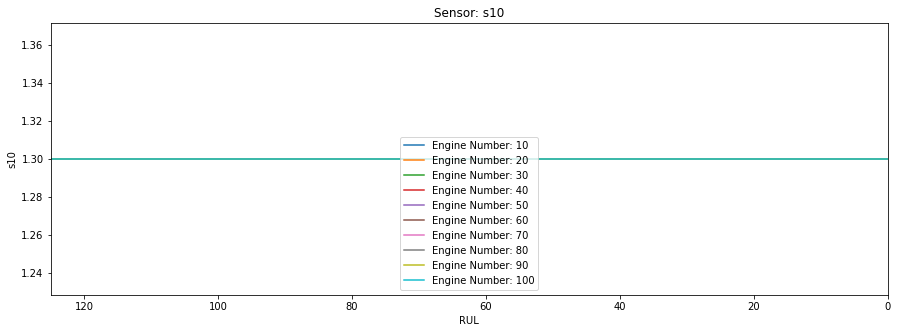

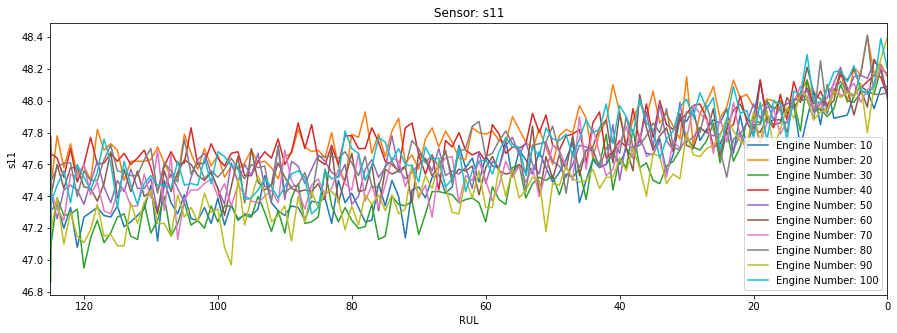

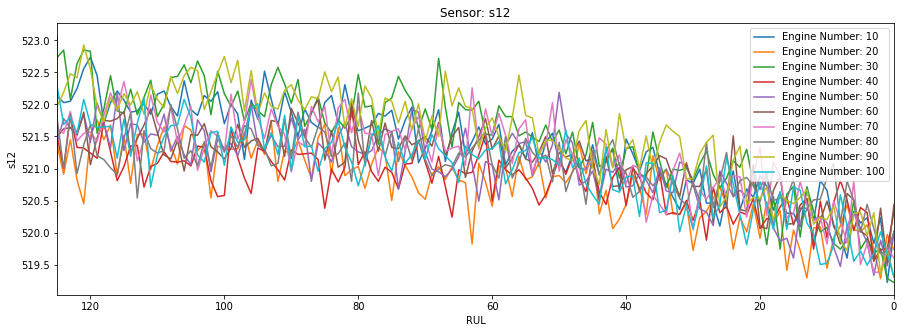

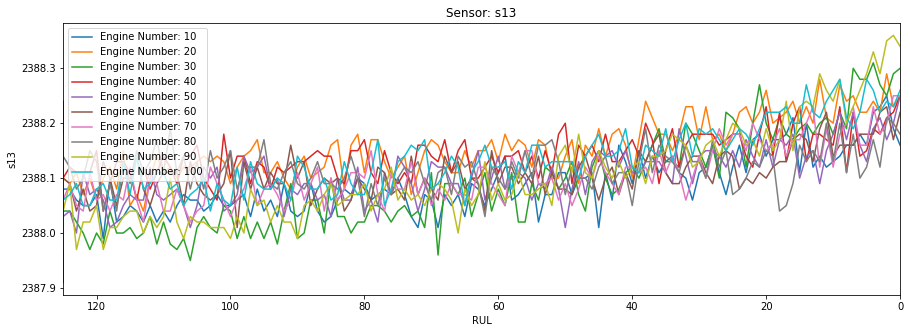

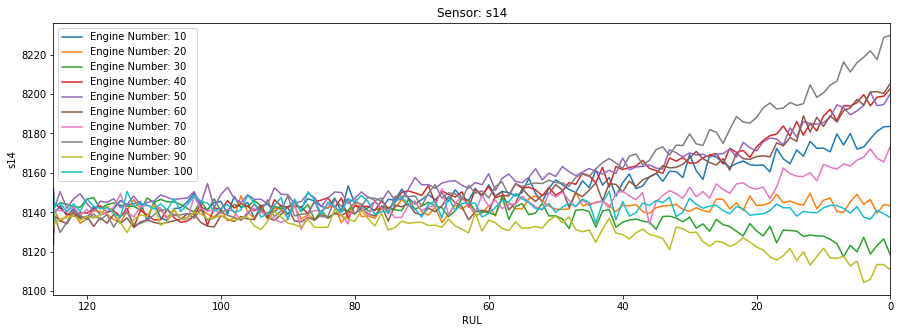

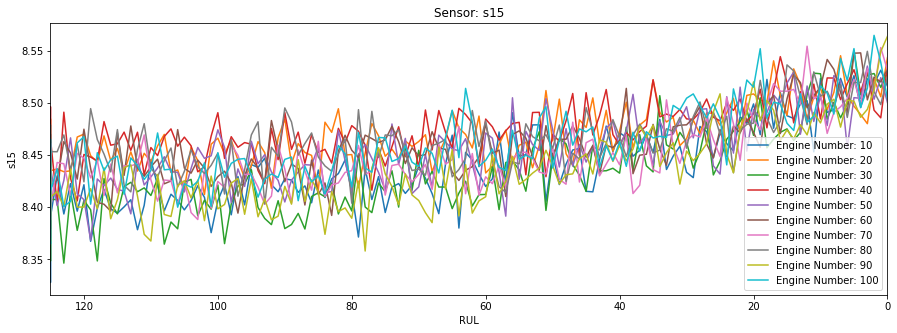

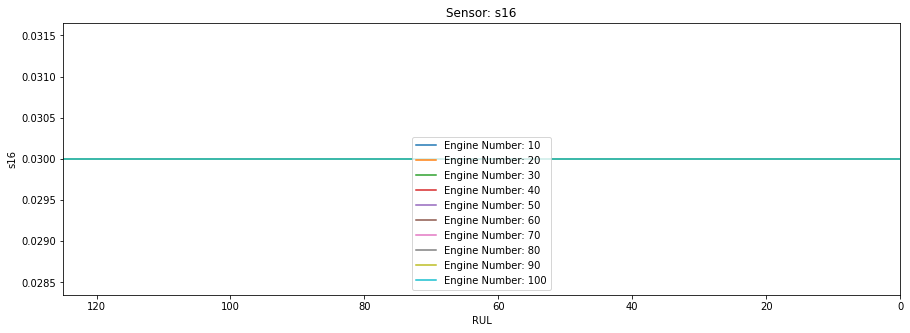

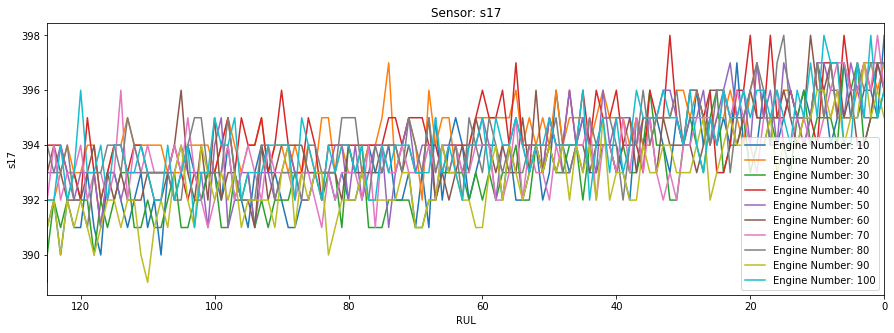

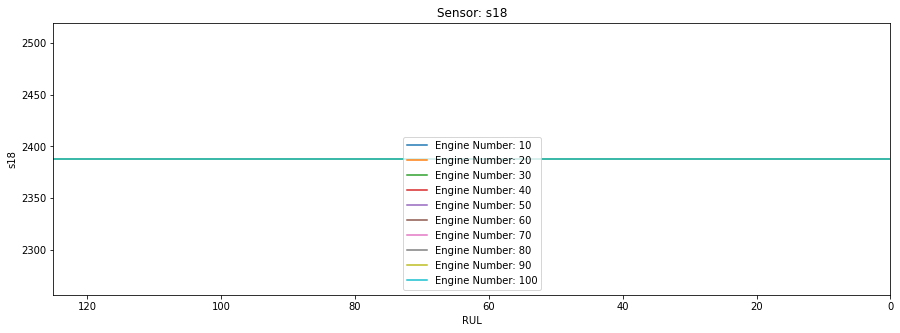

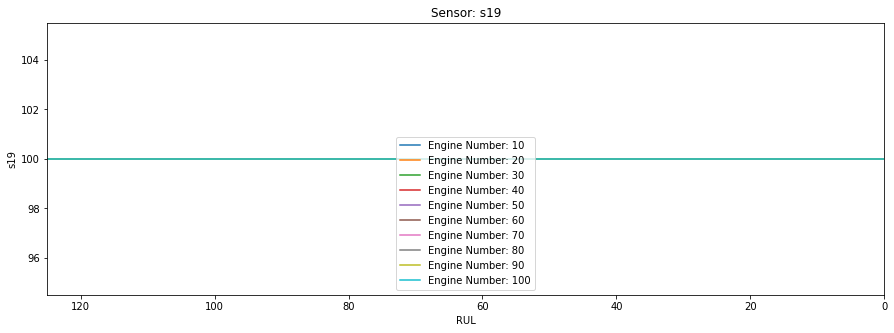

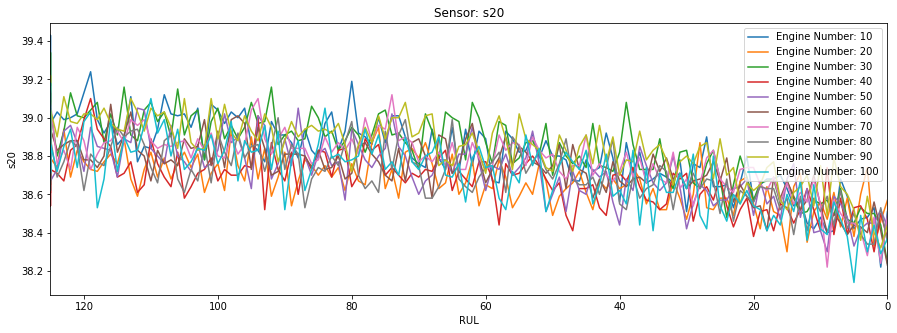

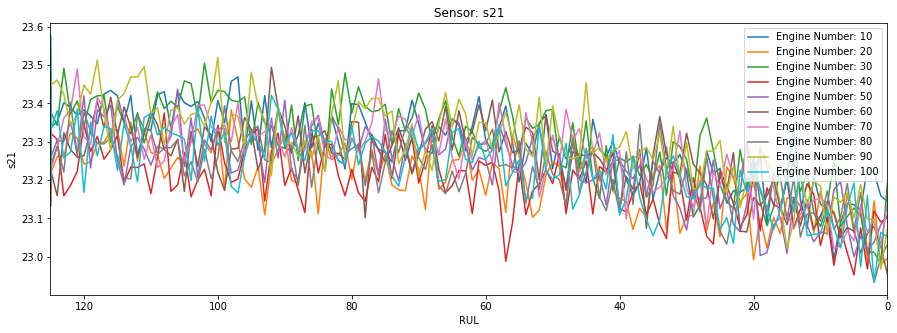

In [15]:
for sensor_name in sensor_names:
    plt.figure(figsize=(15, 5))
    for engine_num in train_data['engine_number'].unique():
        if engine_num % 10 == 0:
            engine_data = train_data[train_data['engine_number'] == engine_num]
            plt.plot(engine_data['rul'], engine_data[sensor_name], label='Engine Number: {}'.format(engine_num))
    plt.xlabel('RUL')
    plt.xlim(125, 0)
    plt.ylabel(sensor_name)
    plt.title('Sensor: {}'.format(sensor_name))
    plt.legend()
    plt.show()

* As already mentioned s1, s5, s6, s10, s16, s18 and s19 are not useful because of their constant nature.
* s2, s3, s4, s8, s11, s13, s15 and s17 show upward trend.
* s6 is weird.
* s7, s12, s20 and s21 show downward trend.
* s9 and s14 has both upward and downward trend.


# Baseline Model

In [16]:
# drop unwanted columns and sensors
dropped_sensor_names =['s1','s5','s6','s10','s16','s18','s19']
dropped_columns = index_names + setting_names + dropped_sensor_names
dropped_columns

['engine_number',
 'time_cycles',
 'setting_1',
 'setting_2',
 'setting_3',
 's1',
 's5',
 's6',
 's10',
 's16',
 's18',
 's19']

In [17]:
# data cleaning
y_train_data = train_data.pop('rul')
x_train_data = train_data.drop(columns=dropped_columns)
y_train_data.head()

0    125
1    125
2    125
3    125
4    125
Name: rul, dtype: int64

In [18]:
x_train_data.head()

,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [20]:
# create
lin_reg = LinearRegression()

# fit
lin_reg.fit(x_train_data, y_train_data)

# make predictions
y_pred = lin_reg.predict(x_train_data)

# calculate r2
r2 = r2_score(y_train_data, y_pred)

# calculate rmse
rmse = np.sqrt(mean_squared_error(y_train_data, y_pred))

print('train set RMSE:{}, R2:{}'.format(rmse, r2))

train set RMSE:21.491018701515422, R2:0.7340432868050445


In [21]:
x_test_data = test_data.groupby('engine_number').last().reset_index()
x_test_data.head()

,engine_number,time_cycles,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [22]:
x_test_data_cleaned = x_test_data.drop(columns=dropped_columns)

In [23]:
x_test_data_cleaned.head()

,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117


In [24]:
y_test_pred = lin_reg.predict(x_test_data_cleaned)
y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred.head()

,0
0,120.693034
1,98.730825
2,73.010144
3,80.933843
4,89.960709


In [26]:
y_test_data = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt', header=None, names=['RUL'])

In [27]:
y_test_data

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [28]:
y_test_data['RUL'].describe()

count    100.00000
mean      75.52000
std       41.76497
min        7.00000
25%       32.75000
50%       86.00000
75%      112.25000
max      145.00000
Name: RUL, dtype: float64

In [29]:
# calculate r2
r2 = r2_score(y_test_data, y_test_pred)

# calculate rmse
rmse = np.sqrt(mean_squared_error(y_test_data, y_test_pred))

# print
print('test set RMSE:{}, R2:{}'.format(rmse, r2))

test set RMSE:21.900213406889716, R2:0.7222608196546444


# Random Forest

In [30]:
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)

In [31]:
rf.fit(x_train_data, y_train_data)

RandomForestRegressor(max_features='sqrt', random_state=42)

In [32]:
y_train_pred = rf.predict(x_train_data)

In [33]:
# calculate r2
r2 = r2_score(y_train_data, y_train_pred)

# calculate rmse
rmse = np.sqrt(mean_squared_error(y_train_data, y_train_pred))

# print
print('train set RMSE:{}, R2:{}'.format(rmse, r2))

train set RMSE:6.764595311335356, R2:0.9736500015836984


In [34]:
y_test_pred = rf.predict(x_test_data_cleaned)

In [35]:
r2 = r2_score(y_test_data, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test_data, y_test_pred))
print('test set RMSE:{}, R2:{}'.format(rmse, r2))

test set RMSE:17.884542376029643, R2:0.8147764857288586


There is a lot of difference between the training set and test set RMSE values. This implies that the Random Forest is overfit. Let us check a decision tree depth and the number of samples at each node.  

In [36]:
print(rf.estimators_[5].tree_.max_depth)
rf.estimators_[5].tree_.n_node_samples


30


array([13025,  9767,  2775, ...,     2,     1,     1], dtype=int64)

As you can see, the number of samples at certain nodes have become one. This shows that the Random Forest became very specific, which is bad. Therefore, we set the tree depth and the minimum number of samples randomly. We will later find the optimised number.  

In [37]:
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42, max_depth=8, min_samples_leaf=50)
rf.fit(x_train_data, y_train_data)
y_train_pred = rf.predict(x_train_data)


r2 = r2_score(y_train_data, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train_data, y_train_pred))

print('train set RMSE:{}, R2:{}'.format(rmse, r2))

train set RMSE:17.876960468903253, R2:0.8159718278507239


In [38]:
y_test_pred = rf.predict(x_test_data_cleaned)

r2 = r2_score(y_test_data, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test_data, y_test_pred))

print('test set RMSE:{}, R2:{}'.format(rmse, r2))

test set RMSE:18.25734865834078, R2:0.8069739718434918


# Decision Tree Visualization

In [40]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import re

def draw_tree(t, df, size=1000, ratio=1, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=True, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

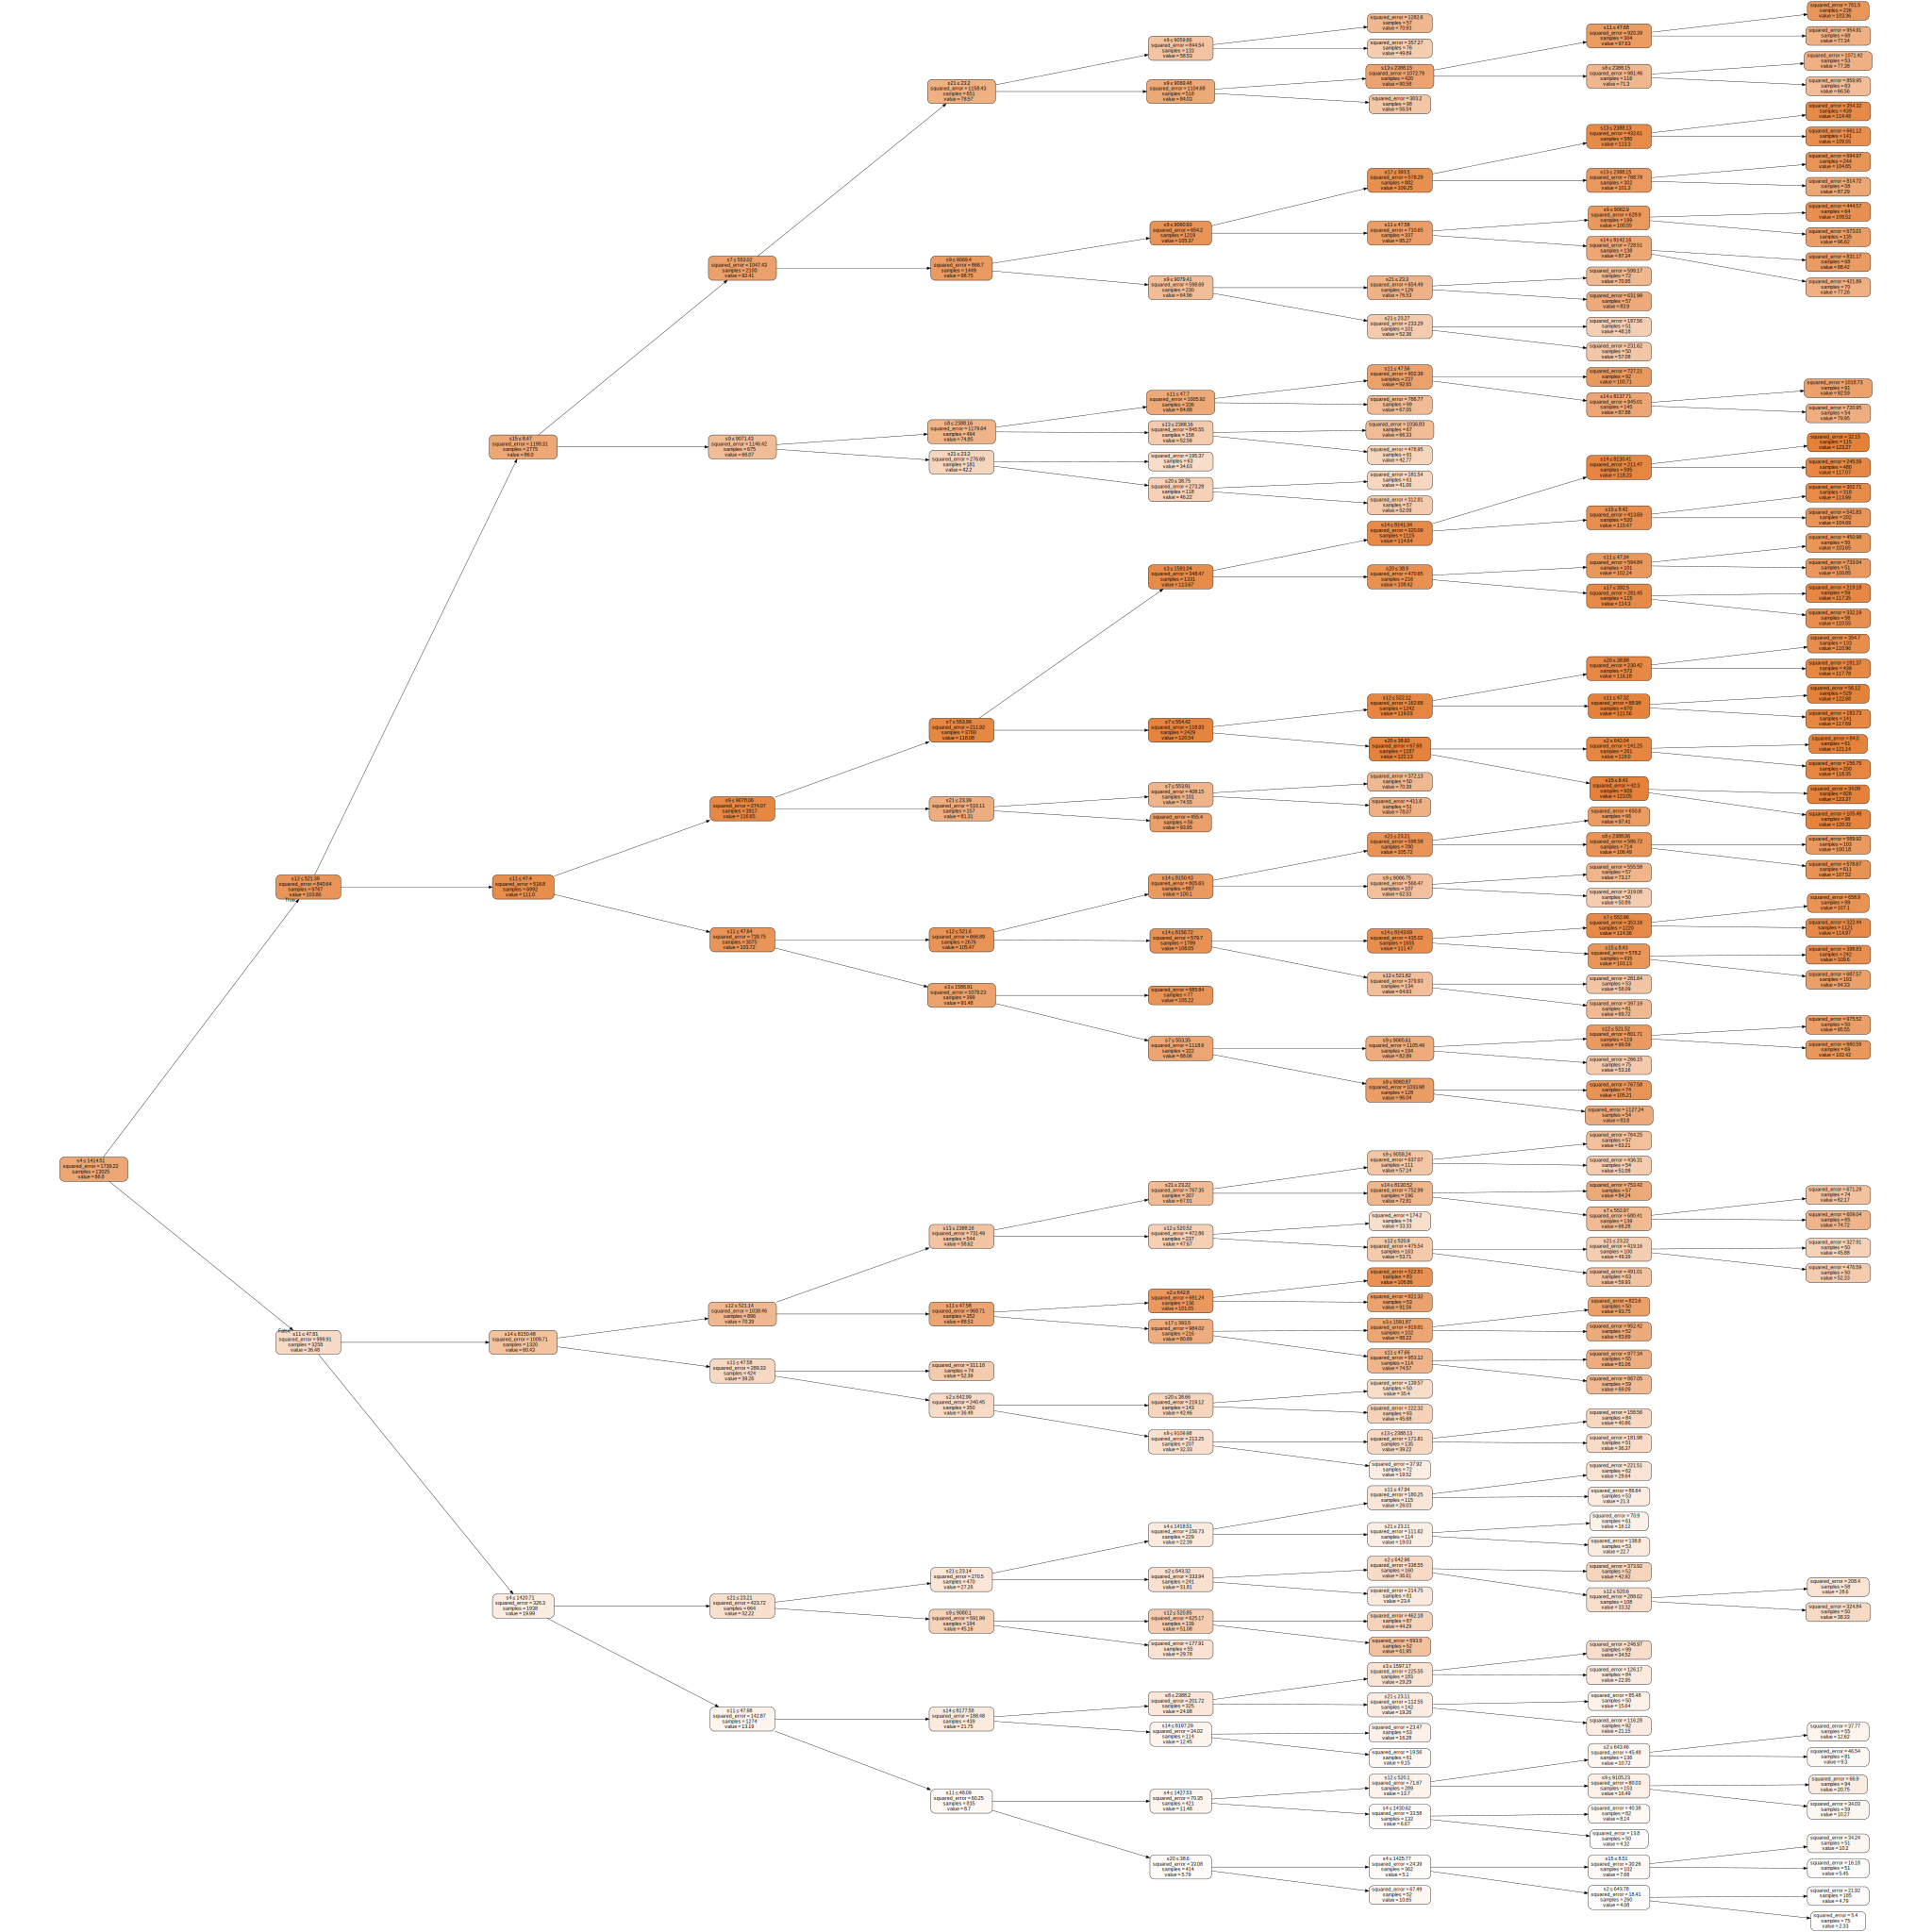

In [41]:
draw_tree(rf.estimators_[5], x_train_data, size=50)

# Hyperparameters tuning
**Cost complexity pruning alpha:** 
Removal of nodes after the fit. Lower ccp_alpha implies overfit. Remove them to generalize better.

In [42]:
path = rf.estimators_[5].cost_complexity_pruning_path(x_train_data,y_train_data)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

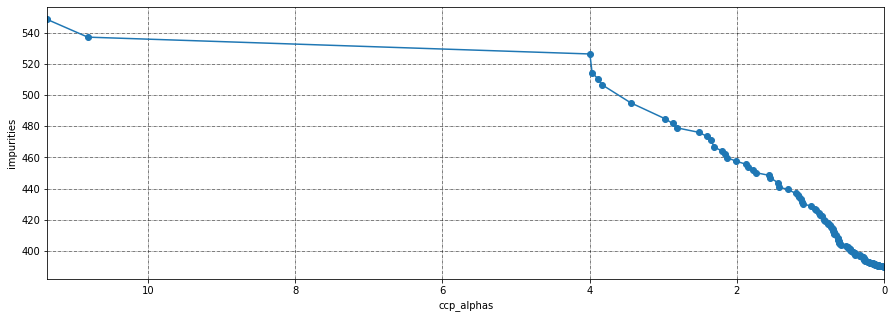

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(ccp_alphas[:-10], impurities[:-10], marker='o')
plt.xlim(max(ccp_alphas[:-10]), min(ccp_alphas[:-10]))
plt.xlabel('ccp_alphas')
plt.ylabel('impurities')
plt.grid(color='black', linestyle='-.', linewidth=0.5)
plt.show()

**Minimum impurity decrease:**
This helps us understand how much error can be reduced. The following picture shows us the formula needed to calculate it.

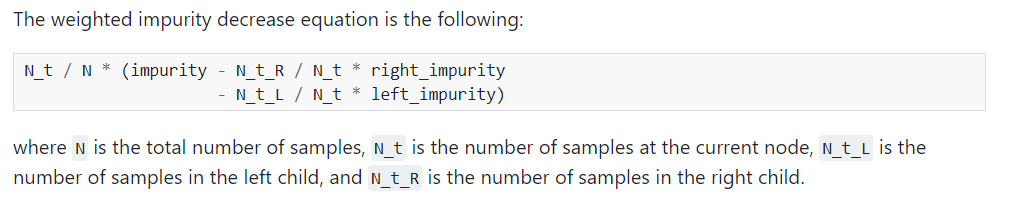

In [44]:
rf_dict = { 
    'node_id': list(range(rf.estimators_[5].tree_.node_count)),
    'left_id': rf.estimators_[5].tree_.children_left,
    'right_id':rf.estimators_[5].tree_.children_right,
    'impurity':rf.estimators_[5].tree_.impurity,
    'samples': rf.estimators_[5].tree_.n_node_samples
            }

In [45]:
impurity_df=pd.DataFrame(rf_dict)
impurity_df.head(10)

,node_id,left_id,right_id,impurity,samples
0,0,1,128,1739.223406,13025
1,1,2,57,840.642185,9767
2,2,3,40,1199.308108,2775
3,3,4,17,1047.429803,2100
4,4,5,8,1158.428277,651
5,5,6,7,844.543666,133
6,6,-1,-1,1282.604442,57
7,7,-1,-1,357.267390,76
8,8,9,16,1104.682538,518
9,9,10,13,1072.792522,420


-1 indicates there are no splits further.

In [46]:
impurity_decrease = []
N = rf.estimators_[5].tree_.node_count
for node_id in impurity_df['node_id']:
    if node_id == 0 or (impurity_df.loc[node_id, 'left_id'] == -1 and impurity_df.loc[node_id, 'right_id'] == -1):
        impurity_decrease.append(0)
    else:
        N_t = impurity_df.loc[node_id, 'samples']
        N_t_L = impurity_df.loc[impurity_df.loc[node_id, 'left_id'], 'samples']
        N_t_R = impurity_df.loc[impurity_df.loc[node_id, 'right_id'], 'samples']
        impurity = impurity_df.loc[node_id, 'impurity']
        right_impurity = impurity_df.loc[impurity_df.loc[node_id, 'right_id'], 'impurity']
        left_impurity = impurity_df.loc[impurity_df.loc[node_id, 'left_id'], 'impurity']
        impurity_decrease.append(N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity))
        

In [47]:
impurity_df['impurity_decrease'] = impurity_decrease
impurity_df['impurity_decrease'].replace(0, np.nan, inplace=True)
impurity_df.head()

,node_id,left_id,right_id,impurity,samples,impurity_decrease
0,0,1,128,1739.223406,13025,NaN
1,1,2,57,840.642185,9767,5577.873959
2,2,3,40,1199.308108,2775,1576.180970
3,3,4,17,1047.429803,2100,829.892696
4,4,5,8,1158.428277,651,309.275316


In [49]:
impurity_df['impurity_decrease'].describe()

count     111.000000
mean      265.941779
std       800.416752
min         0.645033
25%        16.157483
50%        41.798669
75%       149.674771
max      5744.617120
Name: impurity_decrease, dtype: float64

25% values of 'impurity_decrease' lie below 16.157483, which is suitable limit. 

# Random Search

In [52]:
max_depth = list(range(3,34,3))
min_samples_leaf = list(range(1,102,10))
min_impurity_decrease = list(np.arange(0,161.57483)/10)
ccp_alpha = list(np.round(np.linspace(0,2,81), decimals=3))
parameters = {
    'max_depth': max_depth,
    'min_samples_leaf':min_samples_leaf,
    'min_impurity_decrease':min_impurity_decrease,
    'ccp_alpha':ccp_alpha
}

Finding the best possible combination would be very difficult. Using RandomSearch would place the combination in the 95th percentile easily.

# Validation

Random split does not work as a engine value could end up in both training and test set. This makes the model predict more accurately but does not generalize well. Hence, the usage of GroupKFold.

In [54]:
ITERATIONS = 300

rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
gkf = GroupKFold(n_splits=3)


regressor = RandomizedSearchCV(rf, 
                               parameters, 
                               cv = gkf.split(train_data, groups=train_data['engine_number']),
                               verbose=2, 
                               error_score='raise',
                               n_iter=ITERATIONS, 
                               n_jobs=-2,
                               scoring= 'neg_root_mean_squared_error')  
regressor.fit(x_train_data, y_train_data)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] END ccp_alpha=1.675, max_depth=3, min_impurity_decrease=14.1, min_samples_leaf=21; total time=   0.9s
[CV] END ccp_alpha=0.15, max_depth=30, min_impurity_decrease=8.9, min_samples_leaf=71; total time=   1.4s
[CV] END ccp_alpha=1.35, max_depth=24, min_impurity_decrease=4.9, min_samples_leaf=41; total time=   1.6s
[CV] END ccp_alpha=0.55, max_depth=33, min_impurity_decrease=7.1, min_samples_leaf=91; total time=   1.5s
[CV] END ccp_alpha=1.35, max_depth=30, min_impurity_decrease=6.5, min_samples_leaf=11; total time=   1.4s
[CV] END ccp_alpha=0.025, max_depth=33, min_impurity_decrease=3.3, min_samples_leaf=41; total time=   1.7s
[CV] END ccp_alpha=1.65, max_depth=6, min_impurity_decrease=5.2, min_samples_leaf=11; total time=   1.5s
[CV] END ccp_alpha=0.0, max_depth=24, min_impurity_decrease=12.3, min_samples_leaf=71; total time=   1.3s
[CV] END ccp_alpha=0.0, max_depth=30, min_impurity_decrease=14.9, min_samples_leaf=41; t

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f5d5f83da50>,
                   error_score='raise',
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   random_state=42),
                   n_iter=300, n_jobs=-2,
                   param_distributions={'ccp_alpha': [0.0, 0.025, 0.05, 0.075,
                                                      0.1, 0.125, 0.15, 0.175,
                                                      0.2, 0.225, 0.25, 0.275,
                                                      0.3, 0.325, 0.35, 0.375,
                                                      0.4, 0.425, 0.45, 0.475,
                                                      0.5, 0.525, 0.55, 0.575,
                                                      0.6, 0.625, 0.65, 0.675,
                                                      0.7, 0.725, ...],
                                        'max_depth': [3, 6, 9, 12, 15, 18, 

In [55]:
results = pd.DataFrame(regressor.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_impurity_decrease,param_max_depth,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.943610,0.060532,0.032558,0.006433,21,14.1,3,1.675,"{'min_samples_leaf': 21, 'min_impurity_decreas...",-19.409137,-21.255647,-22.158160,-20.940981,1.144128,297
1,1.298806,0.169440,0.047980,0.001707,71,8.9,30,0.15,"{'min_samples_leaf': 71, 'min_impurity_decreas...",-18.109627,-20.536578,-21.481719,-20.042641,1.420265,150
2,1.470063,0.184838,0.050285,0.012073,41,4.9,24,1.35,"{'min_samples_leaf': 41, 'min_impurity_decreas...",-17.397061,-20.308345,-21.137980,-19.614462,1.604104,96
3,1.476209,0.046768,0.049352,0.002856,91,7.1,33,0.55,"{'min_samples_leaf': 91, 'min_impurity_decreas...",-17.925602,-20.456178,-21.342603,-19.908128,1.447813,129
4,1.359125,0.030778,0.034247,0.000405,11,6.5,30,1.35,"{'min_samples_leaf': 11, 'min_impurity_decreas...",-17.730399,-20.428392,-21.327137,-19.828643,1.528377,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.279600,0.090494,0.039538,0.006156,1,13.3,18,0.95,"{'min_samples_leaf': 1, 'min_impurity_decrease...",-18.475860,-20.839678,-21.776085,-20.363875,1.388684,225
296,1.238522,0.091702,0.039119,0.007745,1,15.9,27,1.575,"{'min_samples_leaf': 1, 'min_impurity_decrease...",-18.742087,-20.991597,-21.877051,-20.536911,1.319610,271
297,1.595025,0.181843,0.052440,0.007126,51,1.9,24,1.325,"{'min_samples_leaf': 51, 'min_impurity_decreas...",-16.683645,-19.936922,-20.627613,-19.082727,1.719682,27
298,1.542253,0.094922,0.046022,0.006332,61,0.1,6,1.925,"{'min_samples_leaf': 61, 'min_impurity_decreas...",-16.864734,-20.017395,-20.720225,-19.200784,1.676572,42


In [56]:
columns = ['param_min_samples_leaf', 'param_min_impurity_decrease', 'param_max_depth', 'param_ccp_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']
final_results=results[columns].sort_values('rank_test_score', ascending=True)
final_results

,param_min_samples_leaf,param_min_impurity_decrease,param_max_depth,param_ccp_alpha,mean_test_score,std_test_score,rank_test_score
33,21,0.3,30,0.425,-18.498315,1.910401,1
147,1,0.1,9,0.75,-18.611085,1.865367,2
234,31,0.6,24,0.225,-18.647312,1.844305,3
220,41,0.4,30,0.2,-18.676084,1.872402,4
239,1,1.0,18,0.025,-18.720116,1.864355,5
...,...,...,...,...,...,...,...
62,101,13.8,3,0.25,-20.938634,1.141951,295
0,21,14.1,3,1.675,-20.940981,1.144128,297
134,21,14.1,3,0.65,-20.940981,1.144128,297
119,81,14.7,3,1.8,-20.955341,1.144189,299


In [57]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42,
                           min_samples_leaf=31, min_impurity_decrease=0.6, 
                           max_depth=24, ccp_alpha=0.225)

rf.fit(x_train_data, y_train_data)
y_train_pred = rf.predict(x_train_data)
r2 = r2_score(y_train_data, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train_data, y_train_pred))

print('train set RMSE:{}, R2:{}'.format(rmse, r2))

train set RMSE:17.764464789236506, R2:0.8182806360683025


In [58]:
y_test_pred = rf.predict(x_test_data_cleaned)

r2 = r2_score(y_test_data, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test_data, y_test_pred))

print('test set RMSE:{}, R2:{}'.format(rmse, r2))


test set RMSE:18.037598107219196, R2:0.8115926382179884

[CV] END ccp_alpha=1.825, max_depth=21, min_impurity_decrease=0.0, min_samples_leaf=51; total time=   2.5s
[CV] END ccp_alpha=1.625, max_depth=33, min_impurity_decrease=13.6, min_samples_leaf=91; total time=   1.2s
[CV] END ccp_alpha=0.325, max_depth=15, min_impurity_decrease=2.5, min_samples_leaf=11; total time=   1.6s
[CV] END ccp_alpha=0.225, max_depth=24, min_impurity_decrease=0.6, min_samples_leaf=31; total time=   2.3s
[CV] END ccp_alpha=1.25, max_depth=12, min_impurity_decrease=9.5, min_samples_leaf=51; total time=   1.3s
[CV] END ccp_alpha=1.75, max_depth=21, min_impurity_decrease=2.7, min_samples_leaf=81; total time=   1.3s
[CV] END ccp_alpha=0.675, max_depth=15, min_impurity_decrease=13.7, min_samples_leaf=61; total time=   1.5s
[CV] END ccp_alpha=1.425, max_depth=15, min_impurity_decrease=2.3, min_samples_leaf=31; total time=   1.9s
[CV] END ccp_alpha=0.025, max_depth=18, min_impurity_decrease=1.0, min_samples_leaf=1; 

The test set RMSE is improved by 17.6 percent from our baseline model.